In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [2]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos
import sw_and_int_one_sess as sios

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_disinhibition'
figdir = misc.get_or_create_subdir(figdir)

In [4]:
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
savefn_full = os.path.join(data_dir,'per_field_metrics_shtest_with_1cp.p')
per_field_metrics_all=pickle.load(open(savefn_full,'rb'))

# gpb=per_field_metrics_all.groupby(level=(0,1,4),sort=False)
# fr_nrem_all = []
# for k,val in gpb:
#     fr_nrem=np.ones(val.shape[0]) * cell_metrics_df_all.loc[k,'firingRate_NREMstate']
#     fr_nrem_all.append(pd.Series(fr_nrem,index=val.index))
# fr_nrem_all = pd.concat(fr_nrem_all,axis=0)
    

# per_field_metrics_all['fr_nrem']=fr_nrem_all

In [5]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 


In [6]:
import switch_detection_sweep_penalty_one_session as sdspos
import get_all_switch_add_metrics_pen as gasamp
reload(gasamp)
pen=0.5#0.3#0.3#0.5

best_n_all = {}
X_pwc_all={}
X_raw_all={}
changes_df_all={}
var_res_all={}
corr_all = {}
p_corr_all = {}
all_sw_d_all={}
all_sw_with_metrics_d_all = {}

for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    sw_res_pelt = sdspos.main(data_dir_full,force_reload=False,dosave=False,load_only=True)
    
    sw_info_res_pelt=gasamp.main(data_dir_full,force_reload=False,load_only=True,dosave=False)
    if sw_info_res_pelt is None:
        sw_info_res_pelt=gasamp.main(data_dir_full,force_reload=True,load_only=False)
    all_sw_d = sw_info_res_pelt['all_sw_d_pen'][pen]
    all_sw_d_all[ani,sess] = all_sw_d
    all_sw_with_metrics_d = sw_info_res_pelt['all_sw_with_metrics_d_pen'][pen]
    all_sw_with_metrics_d_all[ani,sess] = all_sw_with_metrics_d
    
    all_sw_res= gasamp.main(data_dir_full,force_reload=False,dosave=False,load_only=True)
    sw_res_pelt = sw_res_pelt[pen]
    
    best_n_all[ani,sess]=sw_res_pelt['best_n']
    X_pwc_all[ani,sess]=sw_res_pelt['X_pwc']
    X_raw_all[ani,sess]=sw_res_pelt['X_raw']
    changes_df_all[ani,sess]=sw_res_pelt['changes_df']
    var_res_all[ani,sess]=sw_res_pelt['var_res']
    corr_all[ani,sess]=sw_res_pelt['corr']
    p_corr_all[ani,sess]=sw_res_pelt['p_corr']
    
best_n_all = pd.concat(best_n_all,axis=0)
X_pwc_all = pd.concat(X_pwc_all,axis=0)
X_raw_all = pd.concat(X_raw_all,axis=0)
changes_df_all = pd.concat(changes_df_all,axis=0)
var_res_all = pd.concat(var_res_all,axis=0)
corr_all = pd.concat(corr_all,axis=0)
p_corr_all = pd.concat(p_corr_all,axis=0)

all_sw_d_all=pd.concat(all_sw_d_all,axis=0)
all_sw_with_metrics_d_all = pd.concat(all_sw_with_metrics_d_all,axis=0)


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/switch_analysis/all_sw_info_pe

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200729/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200729/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m2/e14_2m2_201019/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m2/e14_2m2_201019/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m2/e14_2m2_201019/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/switch_analysis/all_sw_info_pen.p exists; loa

In [8]:
import peer_prediction as pp
reload(pp)

<module 'peer_prediction' from '/mnt/home/szheng/projects/place_variability/code/peer_prediction.py'>

In [9]:
import sw_and_int_withreg as saiw
reload(saiw)

import peer_prediction as pp
reload(sios)
consec_trial_fr_diff_all = {}
sustained_all = {}
transient_all={}
all_sw_with_inh_change_all = {}
for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    sw_and_int_res=saiw.main(data_dir_full,force_reload=False,load_only=True)
    consec_trial_fr_diff=sw_and_int_res['consec_trial_fr_diff_all']
    sustained=sw_and_int_res['sustained']
    transient =sw_and_int_res['transient']
    consec_trial_fr_diff_all[ani,sess] = consec_trial_fr_diff
    sustained_all[ani,sess] = sustained
    transient_all[ani,sess] = transient
    
    all_sw_with_inh_change = sw_and_int_res['all_sw_with_metrics_oneti_with_inh_change']
    all_sw_with_inh_change_all[ani,sess]=all_sw_with_inh_change
    



    
all_sw_with_inh_change_all=pd.concat(all_sw_with_inh_change_all,axis=0)
    
consec_trial_fr_diff_all = pd.concat(consec_trial_fr_diff_all,axis=0)
sustained_all = pd.concat(sustained_all,axis=0)
transient_all = pd.concat(transient_all,axis=0)

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210328/py_data/sw_and_int_exclude_sw_large

In [142]:
data

inh  selected_inh     pyr_1  \
e13_26m1 e13_26m1_210913 0.0  3  0 0  -0.189098     -1.275752  0.565348   
                                   1   0.130961     -0.062743 -0.583429   
                                   2   0.037897     -0.864214 -0.384418   
                                   3   0.907485      1.158292  0.157642   
                                   4  -2.302433     -4.455275 -0.157642   
...                                         ...           ...       ...   
e14_2m3  e14_2m3_201118  both 53 0 19  0.631108     -0.701710 -0.278657   
                                   20  4.037379      9.155352  0.057108   
                                   21 -2.951633     -9.236129  0.097137   
                                   22 -6.839295    -14.978466 -0.161459   
                                   23       NaN           NaN       NaN   

                                          pyr_2     pyr_3     pyr_4     int_1  \
e13_26m1 e13_26m1_210913 0.0  3  0 0  -0.018081 -0.402499 -0.244857 -0.189098   
                                   1  -0.967846 -0.810205 -0.967846  0.130961   
                                   2  -0.226776 -0.384418 -0.384418  0.037897   
                                   3   0.000000  0.000000  0.000000  0.907485   
                                   4  -0.157642 -0.157642 -0.157642 -2.302433   
...                                         ...       ...       ...       ...   
e14_2m3  e14_2m3_201118  both 53 0 19 -0.221549 -0.124412 -0.285871  0.631108   
                                   20  0.154245 -0.007214       NaN  4.037379   
                                   21 -0.064322       NaN       NaN -2.951633   
                                   22       NaN       NaN       NaN -6.839295   
                                   23       NaN       NaN       NaN       NaN   

                                          int_2     int_3     int_4  \
e13_26m1 e13_26m1_210913 0.0  3  0 0  -0.058137 -0.020240  0.887246   
                                   1   0.168858  1.076344 -1.226089   
                                   2   0.945383 -1.357050 -0.097108   
                                   3  -1.394947 -0.135005  0.868624   
                                   4  -1.042491 -0.038861 -1.506386   
...                                         ...       ...       ...   
e14_2m3  e14_2m3_201118  both 53 0 19  4.668487  1.716854 -5.122441   
                                   20  1.085746 -5.753549       NaN   
                                   21 -9.790929       NaN       NaN   
                                   22       NaN       NaN       NaN   
                                   23       NaN       NaN       NaN   

                                       selected_int_1  selected_int_2  \
e13_26m1 e13_26m1_210913 0.0  3  0 0        -1.275752       -1.338495   
                                   1        -0.062743       -0.926957   
                                   2        -0.864214        0.294078   
                                   3         1.158292       -3.296983   
                                   4        -4.455275       -1.124007   
...                                               ...             ...   
e14_2m3  e14_2m3_201118  both 53 0 19       -0.701710        8.453641   
                                   20        9.155352       -0.080777   
                                   21       -9.236129      -24.214594   
                                   22      -14.978466             NaN   
                                   23             NaN             NaN   

                                       selected_int_3  selected_int_4  \
e13_26m1 e13_26m1_210913 0.0  3  0 0        -2.202709       -1.044417   
                                   1         0.231335       -4.223940   
                                   2        -4.161196       -0.829929   
                                   3         0.034285       -0.423471   
                                   4        -1.581762       -2.917308   
..

In [143]:
sw_data

trialtype  uid  field_index         time  \
e13_26m1 e13_26m1_210913 0 0       both  168            1  7918.595083   
                           1        1.0   38            1  7974.689653   
                           2        1.0  125            1  7982.708569   
                           4        1.0  154            3  7976.080179   
                           5        1.0  222            1  7984.987753   
...                                 ...  ...          ...          ...   
e14_2m3  e14_2m3_201118  0 3        0.0   46            1  7094.947600   
                           10      both    3            0  7472.132093   
                           17       1.0   29            0  7905.170286   
                           18       1.0   38            1          NaN   
                           19       0.0   50            0  8139.345206   

                               speed_gauss  field_pos  trial_index  switch  \
e13_26m1 e13_26m1_210913 0 0     33.354894  19.718517            2    -1.0   
                           1     17.427762  96.491241            4    -1.0   
                           2     20.011387  78.110439            4    -1.0   
                           4     17.563432  96.557545            4    -1.0   
                           5     19.576796  91.342096            4    -1.0   
...                                    ...        ...          ...     ...   
e14_2m3  e14_2m3_201118  0 3      5.643747  31.597979            2    -1.0   
                           10    32.875860  18.276324            8    -1.0   
                           17    13.790938  46.165413           15    -1.0   
                           18          NaN        NaN           18    -1.0   
                           19    28.031099   7.586393           19    -1.0   

                               index_within  switch_trial  ...  \
e13_26m1 e13_26m1_210913 0 0              1           2.0  ...   
                           1              2           2.0  ...   
                           2              2           2.0  ...   
                           4              2           2.0  ...   
                           5              2           2.0  ...   
...                                     ...           ...  ...   
e14_2m3  e14_2m3_201118  0 3              2           2.0  ...   
                           10             6           8.0  ...   
                           17             5           5.0  ...   
                           18             6           6.0  ...   
                           19            12          12.0  ...   

                               post_ntrial_le_10_perc_frac_total  \
e13_26m1 e13_26m1_210913 0 0                            0.200000   
                           1                            0.756757   
                           2                            0.378378   
                           4                            0.675676   
                           5                            0.405405   
...                                                          ...   
e14_2m3  e14_2m3_201118  0 3                            0.000000   
                           10                           0.083333   
                           17                           0.000000   
                           18                           0.200000   
                           19                           0.142857   

                               post_ntrial_le_30_perc_frac_total  \
e13_26m1 e13_26m1_210913 0 0                            0.471429   
                           1                            0.918919   
                           2                            0.702703   
                           4                            0.945946   
                           5                            0.837838   
...                                                          ...   
e14_2m3  e14_2m3_201118  0 3                            0.428571   
                           10                     

In [220]:
clean

e13_26m1  e13_26m1_210913  0  0     False
                              1      True
                              2      True
                              3      True
                              4      True
                                    ...  
e14_2m3   e14_2m3_201118   0  15     True
                              16     True
                              17    False
                              18     True
                              19     True
Length: 2624, dtype: bool

In [10]:
data=copy.copy(consec_trial_fr_diff_all)
data['unselected_inh'] = data['inh'] - data['selected_inh']


ti=0
all_sw_with_metrics_d_all_oneti = all_sw_with_metrics_d_all.loc[(slice(None),slice(None),ti),:]


clean = all_sw_with_metrics_d_all_oneti.apply(lambda x:x['pre_ntrial_ge_30_perc_frac_total'] < 0.3 if x['switch']==1 else x['post_ntrial_ge_30_perc_frac_total'] < 0.3,axis=1)
all_sw_with_metrics_d_all_oneti['clean'] = clean



onoff_str_d = {1:'on',-1:'off'}
for sw in [1,-1]:
    sw_data=all_sw_with_metrics_d_all_oneti.query('switch==@sw')
#     sw_data=all_sw_with_metrics_d_all_oneti.query('switch==@sw&clean==True')

    inds=[sw_data.index.get_level_values(0),
        sw_data.index.get_level_values(1),
        sw_data['trialtype'],sw_data['uid'],
        sw_data['field_index'],
        sw_data['switch_trial']-1,
         ]
    # for each switch trial, the reference trial should be the one before that


    inds=pd.MultiIndex.from_arrays(inds)


    onoff_str = onoff_str_d[sw]
    data[f'has_sw_{onoff_str}'] = False
    data.loc[inds,f'has_sw_{onoff_str}']=True
#     data['clean'] = False
#     data.loc[inds,f'clean'] = sw_data['clean']
    
    inds=[sw_data.index.get_level_values(0),
        sw_data.index.get_level_values(1),
        sw_data['trialtype'],sw_data['uid'],
        sw_data['field_index']]
    
    inds=pd.MultiIndex.from_arrays(inds)
    data[f'field_has_sw_{onoff_str}'] = False
    for ind in inds:
        data.loc[ind,f'field_has_sw_{onoff_str}']=True

/tmp/ipykernel_222449/3968312519.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_sw_with_metrics_d_all_oneti['clean'] = clean
/tmp/ipykernel_222449/3968312519.py:45: PerformanceWarning: indexing past lexsort depth may impact performance.
  data.loc[ind,f'field_has_sw_{onoff_str}']=True
/tmp/ipykernel_222449/3968312519.py:45: PerformanceWarning: indexing past lexsort depth may impact performance.
  data.loc[ind,f'field_has_sw_{onoff_str}']=True


In [14]:
reload(ph)

<module 'plot_helper' from '/mnt/home/szheng/projects/util_code/plot_helper.py'>

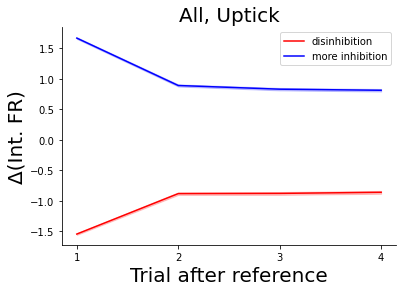

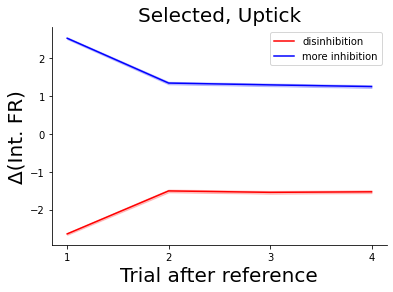

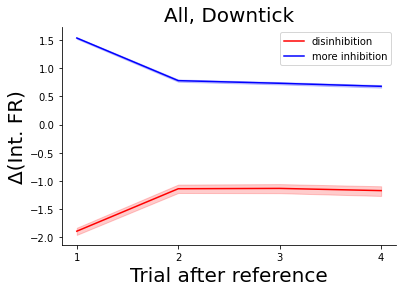

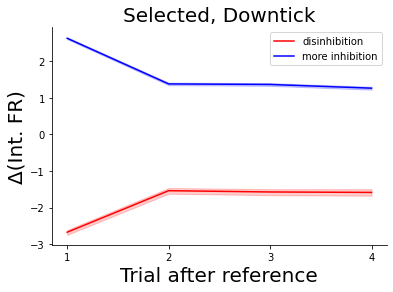

In [130]:
cols_reset = np.arange(1,5)
var_name='Trial after reference'
ylabel = u'Δ(Int. FR)'
kwargs = dict(cols_reset=cols_reset,var_name=var_name)
title_key_d = {'inh':'All','selected_inh':'Selected','unselected_inh':'All - Selected'}
int_thresh = 0.
pyr_thresh = 0.
ma_updown_d = {'Uptick':data['pyr_1']>pyr_thresh,
               'Downtick':data['pyr_1']<-pyr_thresh
              }
savefig = True#False
# fig,axs=plt.subplots(3,2,figsize=(2*6,3*4),sharex=True)
for ii,(updown, ma_updown) in enumerate(ma_updown_d.items()):
    for jj,inh_key in enumerate(['inh','selected_inh']):
        if inh_key=='inh':
            plot_inh_key='int'
        else:
            plot_inh_key='selected_int'
#         ax = axs[jj,ii]
        fig,ax=plt.subplots()
#         ma = (data['pyr_1']>pyr_thresh) & (data[inh_key] < -int_thresh)
        ma = ma_updown & (data[inh_key] < -int_thresh)
        toplot=data.loc[ma].loc[:,f'{plot_inh_key}_1':f'{plot_inh_key}_4']
        fig,ax=ph.mean_across_row_vs_col_with_err(toplot,label='disinhibition',fig=fig,ax=ax,color='red',**kwargs)


#         ma = (data['pyr_1']>pyr_thresh) & (data[inh_key] > int_thresh)
        ma = ma_updown & (data[inh_key] > int_thresh)
        toplot=data.loc[ma].loc[:,f'{plot_inh_key}_1':f'{plot_inh_key}_4']
        fig,ax=ph.mean_across_row_vs_col_with_err(toplot,label='more inhibition',fig=fig,ax=ax,color='blue',**kwargs)
        ax.set(ylabel=ylabel)
        title = f'{title_key_d[inh_key]}, {updown}'
        ax.set_title(title)
        sns.despine()
        if savefig:
            fig_fn=os.path.join(figdir,f'delta_int_{title_key_d[inh_key]}_{updown}.svg')
            fig.savefig(fig_fn,bbox_inches='tight')
            fig_fn=os.path.join(figdir,f'delta_int_{title_key_d[inh_key]}_{updown}.png')
            fig.savefig(fig_fn,bbox_inches='tight')
# plt.tight_layout()

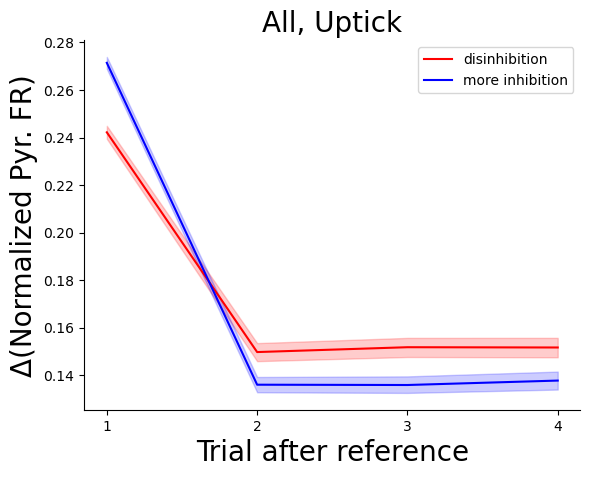

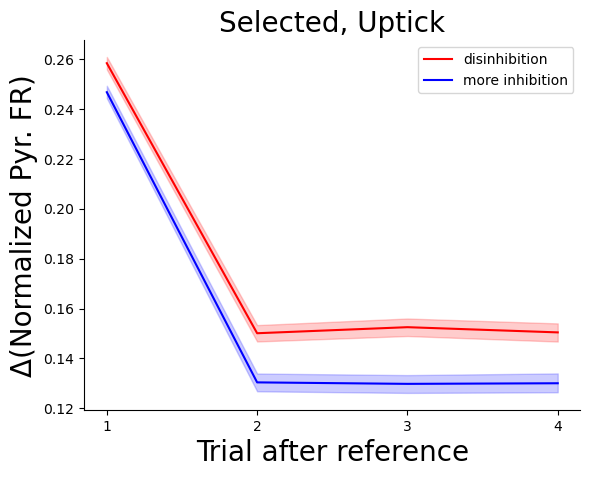

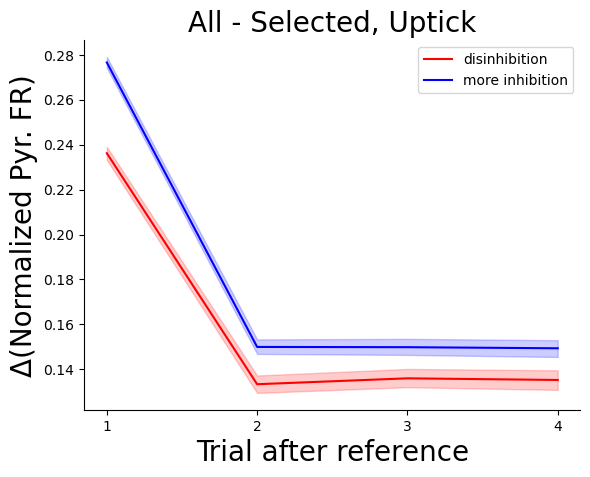

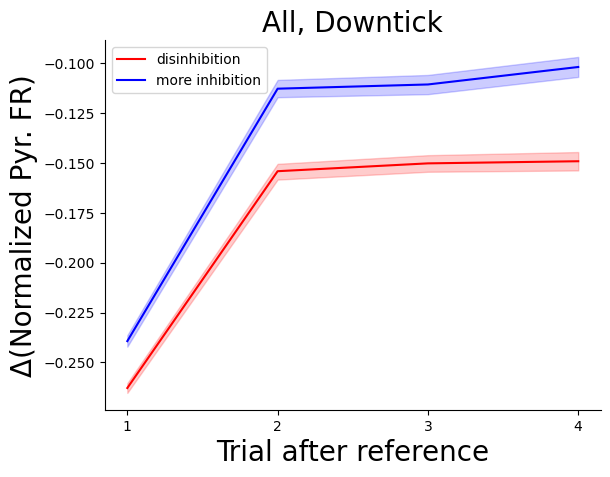

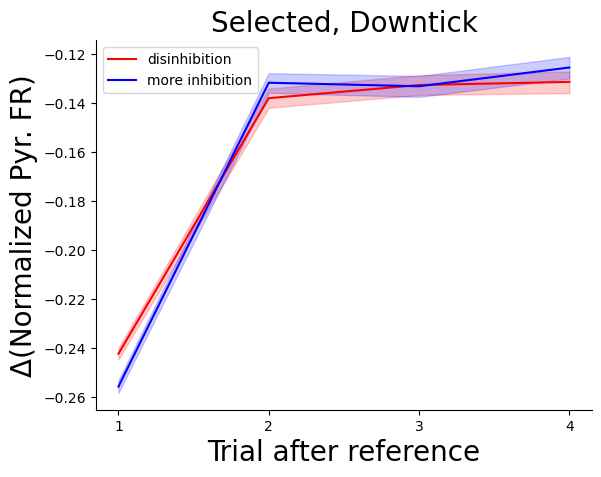

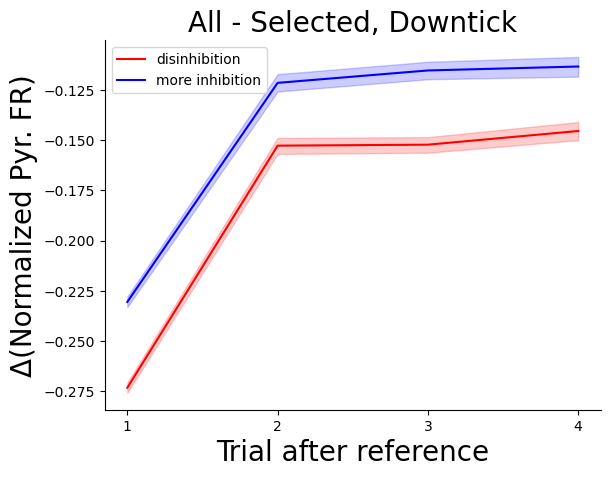

In [61]:
cols_reset = np.arange(1,5)
var_name='Trial after reference'
ylabel = u'Δ(Normalized Pyr. FR)'
kwargs = dict(cols_reset=cols_reset,var_name=var_name)
title_key_d = {'inh':'All','selected_inh':'Selected','unselected_inh':'All - Selected'}
int_thresh = 0.
pyr_thresh = 0.
ma_updown_d = {'Uptick':data['pyr_1']>pyr_thresh,
               'Downtick':data['pyr_1']<-pyr_thresh
              }
savefig = True
# fig,axs=plt.subplots(3,2,figsize=(2*6,3*4),sharex=True)
for ii,(updown, ma_updown) in enumerate(ma_updown_d.items()):
    for jj,inh_key in enumerate(['inh','selected_inh','unselected_inh']):
        
#         ax = axs[jj,ii]
        fig,ax=plt.subplots()
#         ma = (data['pyr_1']>pyr_thresh) & (data[inh_key] < -int_thresh)
        ma = ma_updown & (data[inh_key] < -int_thresh)
        toplot=data.loc[ma].loc[:,'pyr_1':'pyr_4']
        fig,ax=ph.mean_across_row_vs_col_with_err(toplot,label='disinhibition',fig=fig,ax=ax,color='red',**kwargs)


#         ma = (data['pyr_1']>pyr_thresh) & (data[inh_key] > int_thresh)
        ma = ma_updown & (data[inh_key] > int_thresh)
        toplot=data.loc[ma].loc[:,'pyr_1':'pyr_4']
        fig,ax=ph.mean_across_row_vs_col_with_err(toplot,label='more inhibition',fig=fig,ax=ax,color='blue',**kwargs)
        ax.set(ylabel=ylabel)
        title = f'{title_key_d[inh_key]}, {updown}'
        ax.set_title(title)
        sns.despine()
        if savefig:
            fig_fn=os.path.join(figdir,f'delta_pyr_{title_key_d[inh_key]}_{updown}.svg')
            fig.savefig(fig_fn,bbox_inches='tight')
            fig_fn=os.path.join(figdir,f'delta_pyr_{title_key_d[inh_key]}_{updown}.png')
            fig.savefig(fig_fn,bbox_inches='tight')
# plt.tight_layout()

# control for autocorrelation

In [11]:
import statsmodels.stats.api as sms

In [12]:
cols_reset = np.arange(1,5)
var_name='Trial after reference'
ylabel = u'Δ(Normalized Pyr. FR)'
kwargs = dict(cols_reset=cols_reset,var_name=var_name)
title_key_d = {'inh':'All','selected_inh':'Selected','unselected_inh':'All - Selected'}
int_thresh = 0.
pyr_thresh = 0.
ma_updown_d = {'Uptick':data['pyr_1']>pyr_thresh,
               'Downtick':data['pyr_1']<-pyr_thresh
              }
savefig = False


In [13]:
inh_key = 'selected_inh'

In [16]:
def filter_tick_group_get_diff_ci(data,ma_common,ma_group_l,doplot=False,neuron_type='pyr'):
#     ma = ma_updown & (data[inh_key] < -int_thresh)
    ma = ma_common&ma_group_l[0]
    pyr_disinh=data.loc[ma].loc[:,f'{neuron_type}_1':f'{neuron_type}_4']
    # fig,ax=ph.mean_across_row_vs_col_with_err(toplot,label='disinhibition',fig=fig,ax=ax,color='red',**kwargs)
#     ma = ma_updown & (data[inh_key] > int_thresh)
    ma = ma_common&ma_group_l[1]
    pyr_inh=data.loc[ma].loc[:,f'{neuron_type}_1':f'{neuron_type}_4']
    # fig,ax=ph.mean_across_row_vs_col_with_err(toplot,label='more inhibition',fig=fig,ax=ax,color='blue',**kwargs)
    
    t_l = []
    p_l = []
    ci_l = []
    diff_l = []
    for k in pyr_disinh.columns:
        X1=pyr_disinh[k].dropna()
        X2=pyr_inh[k].dropna()
        cm=sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
        ci = cm.tconfint_diff()
        t,p,_ = cm.ttest_ind()
        diff = np.mean(ci)
        diff_l.append(diff)
        t_l.append(t)
        p_l.append(p)
        ci_l.append(ci)
    diff_l = np.array(diff_l)
    ci_l =np.array(ci_l).T
    if doplot:
        fig,ax=plt.subplots()
        ax.errorbar(np.arange(len(diff_l)),diff_l,yerr=np.abs(ci_l-diff_l[None,:]))
    
    return diff_l,ci_l


In [120]:
data.columns

Index(['inh', 'selected_inh', 'pyr_1', 'pyr_2', 'pyr_3', 'pyr_4', 'int_1',
       'int_2', 'int_3', 'int_4', 'selected_int_1', 'selected_int_2',
       'selected_int_3', 'selected_int_4', 'fr_prior', 'unselected_inh',
       'has_sw_on', 'has_sw_off'],
      dtype='object')

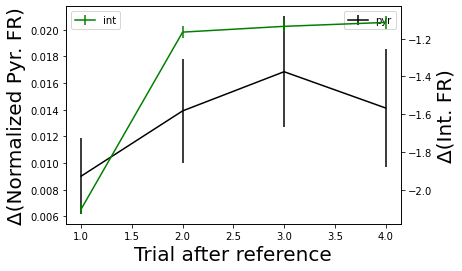

In [28]:
ma_common = (data['pyr_1']>pyr_thresh)
inh_key = 'selected_int'#'int'
ma_group_l = [(data[f'{inh_key}_1'] <-int_thresh),
              (data[f'{inh_key}_1'] >int_thresh)
]


neuron_type = 'pyr'
pyr_diff_l,pyr_ci_l = filter_tick_group_get_diff_ci(data,ma_common,ma_group_l,doplot=False,neuron_type=neuron_type)

neuron_type = 'int'
int_diff_l,int_ci_l = filter_tick_group_get_diff_ci(data,ma_common,ma_group_l,doplot=False,neuron_type=neuron_type)


fig,ax=plt.subplots()
ax.errorbar(1+np.arange(len(pyr_diff_l)),pyr_diff_l,yerr=np.abs(pyr_ci_l-pyr_diff_l[None,:]),color='k',label='pyr')
ax.set_xlabel('Trial after reference')
ax.set_ylabel(u'Δ(Normalized Pyr. FR)')
ax.legend()
ax2=ax.twinx()
ax2.set_ylabel(u'Δ(Int. FR)')
ax2.errorbar(1+np.arange(len(int_diff_l)),int_diff_l,yerr=np.abs(int_ci_l-int_diff_l[None,:]),c='green',label='int')
ax2.legend()



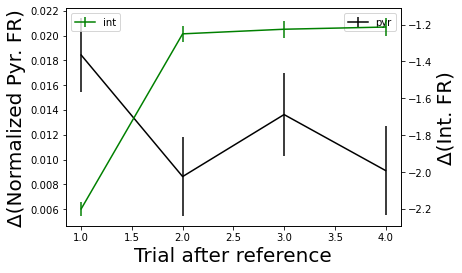

In [29]:
ma_common = np.ones(data.shape[0],dtype=bool)#(data['pyr_1']>pyr_thresh)
inh_key = 'selected_int'#'int'
ma_group_l = [(data[f'{inh_key}_1'] <-int_thresh),
              (data[f'{inh_key}_1'] >int_thresh)
]


neuron_type = 'pyr'
pyr_diff_l,pyr_ci_l = filter_tick_group_get_diff_ci(data,ma_common,ma_group_l,doplot=False,neuron_type=neuron_type)

neuron_type = 'int'
int_diff_l,int_ci_l = filter_tick_group_get_diff_ci(data,ma_common,ma_group_l,doplot=False,neuron_type=neuron_type)


fig,ax=plt.subplots()
ax.errorbar(1+np.arange(len(pyr_diff_l)),pyr_diff_l,yerr=np.abs(pyr_ci_l-pyr_diff_l[None,:]),color='k',label='pyr')
ax.set_xlabel('Trial after reference')
ax.set_ylabel(u'Δ(Normalized Pyr. FR)')
ax.legend()
ax2=ax.twinx()
ax2.set_ylabel(u'Δ(Int. FR)')
ax2.errorbar(1+np.arange(len(int_diff_l)),int_diff_l,yerr=np.abs(int_ci_l-int_diff_l[None,:]),c='green',label='int')
ax2.legend()



In [120]:
# compare fraction
ma_common = (data['pyr_1']>pyr_thresh) & (data[f'{inh_key}_2']>int_thresh)
ma_group_l = [(data[f'{inh_key}_1'] <-int_thresh),
              (data[f'{inh_key}_1'] >int_thresh)
]

frac_key = 'pyr_2'
frac_func = np.greater
frac_thresh=0
nobs_l = []
counts_l = []
for ma_group in ma_group_l:
    ma = ma_common&ma_group
    xx=data.loc[ma]
    xx = frac_func(xx[frac_key],frac_thresh)
    nobs = xx.shape[0]
    counts=xx.sum()
    nobs_l.append(nobs)
    counts_l.append(counts)
    

from statsmodels.stats.proportion import proportions_ztest
proportions_ztest(counts_l,nobs_l)

(-4.189395061258487, 2.796990892445569e-05)

(-4.189395061258487, 2.796990892445569e-05)

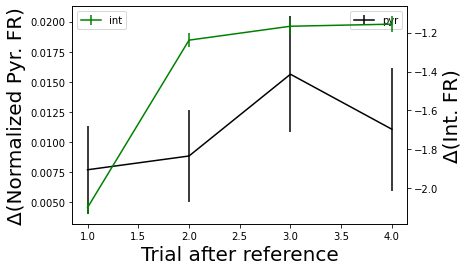

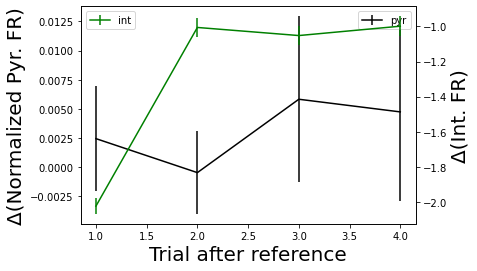

In [108]:
pyr_thresh=0.
ma_common = (data['pyr_1']>pyr_thresh)&(data['pyr_2']>pyr_thresh)
inh_key = 'selected_int'#'int'
ma_group_l = [(data[f'{inh_key}_1'] <-int_thresh),
              (data[f'{inh_key}_1'] >int_thresh)
]


neuron_type = 'pyr'
pyr_diff_l,pyr_ci_l = filter_tick_group_get_diff_ci(data,ma_common,ma_group_l,doplot=False,neuron_type=neuron_type)

neuron_type = 'int'
int_diff_l,int_ci_l = filter_tick_group_get_diff_ci(data,ma_common,ma_group_l,doplot=False,neuron_type=neuron_type)


fig,ax=plt.subplots()
ax.errorbar(1+np.arange(len(pyr_diff_l)),pyr_diff_l,yerr=np.abs(pyr_ci_l-pyr_diff_l[None,:]),color='k',label='pyr')
ax.set_xlabel('Trial after reference')
ax.set_ylabel(u'Δ(Normalized Pyr. FR)')
ax.legend()
ax2=ax.twinx()
ax2.set_ylabel(u'Δ(Int. FR)')
ax2.errorbar(1+np.arange(len(int_diff_l)),int_diff_l,yerr=np.abs(int_ci_l-int_diff_l[None,:]),c='green',label='int')
ax2.legend()

ma_common = (data['pyr_1']>pyr_thresh)&(data['pyr_2']<-pyr_thresh)
inh_key = 'selected_int'#'int'
ma_group_l = [(data[f'{inh_key}_1'] <-int_thresh),
              (data[f'{inh_key}_1'] >int_thresh)
]


neuron_type = 'pyr'
pyr_diff_l,pyr_ci_l = filter_tick_group_get_diff_ci(data,ma_common,ma_group_l,doplot=False,neuron_type=neuron_type)

neuron_type = 'int'
int_diff_l,int_ci_l = filter_tick_group_get_diff_ci(data,ma_common,ma_group_l,doplot=False,neuron_type=neuron_type)


fig,ax=plt.subplots()
ax.errorbar(1+np.arange(len(pyr_diff_l)),pyr_diff_l,yerr=np.abs(pyr_ci_l-pyr_diff_l[None,:]),color='k',label='pyr')
ax.set_xlabel('Trial after reference')
ax.set_ylabel(u'Δ(Normalized Pyr. FR)')
ax.legend()
ax2=ax.twinx()
ax2.set_ylabel(u'Δ(Int. FR)')
ax2.errorbar(1+np.arange(len(int_diff_l)),int_diff_l,yerr=np.abs(int_ci_l-int_diff_l[None,:]),c='green',label='int')
ax2.legend()



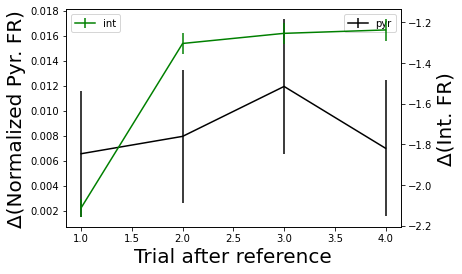

In [37]:
ma_common = (data['pyr_1']>pyr_thresh)&(data['pyr_2']>pyr_thresh)&(data['pyr_3']>pyr_thresh)&(data['pyr_4']>pyr_thresh)
inh_key = 'selected_int'#'int'
ma_group_l = [(data[f'{inh_key}_1'] <-int_thresh),
              (data[f'{inh_key}_1'] >int_thresh)
]


neuron_type = 'pyr'
pyr_diff_l,pyr_ci_l = filter_tick_group_get_diff_ci(data,ma_common,ma_group_l,doplot=False,neuron_type=neuron_type)

neuron_type = 'int'
int_diff_l,int_ci_l = filter_tick_group_get_diff_ci(data,ma_common,ma_group_l,doplot=False,neuron_type=neuron_type)


fig,ax=plt.subplots()
ax.errorbar(1+np.arange(len(pyr_diff_l)),pyr_diff_l,yerr=np.abs(pyr_ci_l-pyr_diff_l[None,:]),color='k',label='pyr')
ax.set_xlabel('Trial after reference')
ax.set_ylabel(u'Δ(Normalized Pyr. FR)')
ax.legend()
ax2=ax.twinx()
ax2.set_ylabel(u'Δ(Int. FR)')
ax2.errorbar(1+np.arange(len(int_diff_l)),int_diff_l,yerr=np.abs(int_ci_l-int_diff_l[None,:]),c='green',label='int')
ax2.legend()



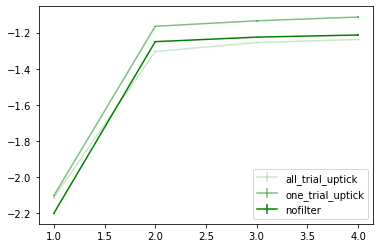

In [36]:
ma_common = (data['pyr_1']>pyr_thresh)&(data['pyr_2']>pyr_thresh)&(data['pyr_3']>pyr_thresh)&(data['pyr_4']>pyr_thresh)
inh_key = 'selected_int'#'int'
ma_group_l = [(data[f'{inh_key}_1'] <-int_thresh),
              (data[f'{inh_key}_1'] >int_thresh)
]

ma_common = (data['pyr_1']>pyr_thresh)
ma_common_d={
    'all_trial_uptick':(data['pyr_1']>pyr_thresh)&(data['pyr_2']>pyr_thresh)&(data['pyr_3']>pyr_thresh)&(data['pyr_4']>pyr_thresh),
    'one_trial_uptick':(data['pyr_1']>pyr_thresh),
    'nofilter':np.ones(data.shape[0],dtype=bool)
}

fig,ax=plt.subplots()
alpha_l = [0.2,0.5,1.]
for ii,(kk,ma_common) in enumerate(ma_common_d.items()):
    neuron_type = 'pyr'
    pyr_diff_l,pyr_ci_l = filter_tick_group_get_diff_ci(data,ma_common,ma_group_l,doplot=False,neuron_type=neuron_type)

    neuron_type = 'int'
    int_diff_l,int_ci_l = filter_tick_group_get_diff_ci(data,ma_common,ma_group_l,doplot=False,neuron_type=neuron_type)



    ax.errorbar(1+np.arange(len(pyr_diff_l)),int_diff_l,yerr=np.abs(pyr_ci_l-pyr_diff_l[None,:]),color='green',label=kk,alpha=alpha_l[ii])
ax.legend()

In [38]:
import statsmodels
import statsmodels.formula.api as smf

In [44]:
inh_key

'selected_int'

In [97]:
data_for_reg = copy.copy(data)
pyr_thresh = 0.6#0
int_thresh=0
data_for_reg = data_for_reg.loc[data_for_reg['pyr_1'] > pyr_thresh]
# data_for_reg = data_for_reg.loc[data_for_reg['pyr_1'] <- pyr_thresh]
inh_key ='selected_int'
# inh_key ='int'
data_for_reg['inh_sign'] = data_for_reg[f'{inh_key}_1'] >int_thresh
# data_for_reg = data_for_reg.loc[(data_for_reg['pyr_1'] > pyr_thresh)&(data_for_reg['pyr_2'] > pyr_thresh)]
# data_for_reg = data_for_reg.loc[(data_for_reg['pyr_1'] <- pyr_thresh)&(data_for_reg['pyr_2'] > pyr_thresh)]

In [104]:
pyr_lag = 2
int_lag_control = 1
int_lag_predict = 2
res_control=smf.ols(f'pyr_{pyr_lag}~{inh_key}_{int_lag_control}',data=data_for_reg).fit()
print(res_control.summary())
data_for_reg['resid'] = res_control.resid
res_final = smf.ols(f'resid~{inh_key}_{int_lag_predict}',data=data_for_reg).fit()
res_final.summary()

                            OLS Regression Results                            
Dep. Variable:                  pyr_2   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.118
Date:                Thu, 28 Sep 2023   Prob (F-statistic):             0.0775
Time:                        17:05:38   Log-Likelihood:                -1486.7
No. Observations:                6910   AIC:                             2977.
Df Residuals:                    6908   BIC:                             2991.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2653      0.004     73.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  resid   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     63.83
Date:                Thu, 28 Sep 2023   Prob (F-statistic):           1.57e-15
Time:                        17:05:38   Log-Likelihood:                -1454.9
No. Observations:                6910   AIC:                             2914.
Df Residuals:                    6908   BIC:                             2928.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0023      0.004     -0.640      0.522      -0.009       0.005
selected_int_2    -0.0062      0.001     -7.990      0.000      -0.008      -0.005
==============================================================================
Omnibus:                      319.608   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              313.422
Skew:                           0.478   Prob(JB):                     8.73e-69
Kurtosis:                       2.582   Cond. No.                         4.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [127]:
pyr_lag = 2
int_lag_control = 1#2
int_lag_predict = 2#1
inh_key = 'selected_int'
res_control=smf.ols(f'{inh_key}_{int_lag_predict}~{inh_key}_{int_lag_control}',data=data_for_reg).fit()
print(res_control.summary())
data_for_reg['resid'] = res_control.resid
res_final = smf.ols(f'pyr_{pyr_lag}~resid',data=data_for_reg).fit()
res_final.summary()

                            OLS Regression Results                            
Dep. Variable:         selected_int_2   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     3003.
Date:                Thu, 28 Sep 2023   Prob (F-statistic):               0.00
Time:                        17:50:12   Log-Likelihood:                -19139.
No. Observations:                6910   AIC:                         3.828e+04
Df Residuals:                    6908   BIC:                         3.830e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.1571      0.047     -3.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pyr_2   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     91.91
Date:                Thu, 28 Sep 2023   Prob (F-statistic):           1.23e-21
Time:                        17:50:12   Log-Likelihood:                -1442.6
No. Observations:                6910   AIC:                             2889.
Df Residuals:                    6908   BIC:                             2903.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2658      0.004     74.095      0.000       0.259       0.273
resid         -0.0089      0.001     -9.587      0.000      -0.011      -0.007
==============================================================================
Omnibus:                      312.099   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              311.263
Skew:                           0.480   Prob(JB):                     2.57e-68
Kurtosis:                       2.602   Cond. No.                         3.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<ErrorbarContainer object of 3 artists>

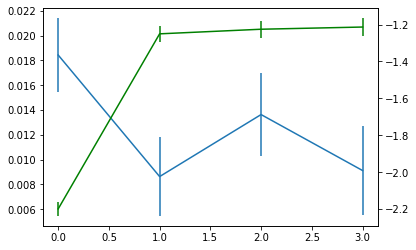

In [18]:
ma_common = np.ones(data.shape[0],dtype=bool)#(data['pyr_1']>pyr_thresh)#&(data['field_has_sw_on'])#(data['pyr_1']>pyr_thresh)&(data['pyr_2']>pyr_thresh)#

inh_key = 'selected_int'#'int'
ma_group_l = [(data[f'{inh_key}_1'] <-int_thresh),
              (data[f'{inh_key}_1'] >int_thresh)
]


neuron_type = 'pyr'
pyr_diff_l,pyr_ci_l = filter_tick_group_get_diff_ci(data,ma_common,ma_group_l,doplot=False,neuron_type=neuron_type)

neuron_type = 'int'
int_diff_l,int_ci_l = filter_tick_group_get_diff_ci(data,ma_common,ma_group_l,doplot=False,neuron_type=neuron_type)


fig,ax=plt.subplots()
ax.errorbar(np.arange(len(pyr_diff_l)),pyr_diff_l,yerr=np.abs(pyr_ci_l-pyr_diff_l[None,:]))
ax2=ax.twinx()
ax2.errorbar(np.arange(len(int_diff_l)),int_diff_l,yerr=np.abs(int_ci_l-int_diff_l[None,:]),c='green')

<ErrorbarContainer object of 3 artists>

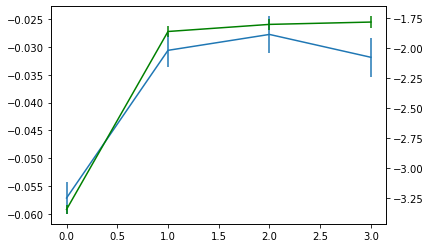

In [19]:
ma_common = np.ones(data.shape[0],dtype=bool)#(data['pyr_1']>pyr_thresh)#np.ones(data.shape[0],dtype=bool)#(data['pyr_1']>pyr_thresh)&(data['pyr_2']>pyr_thresh)#
# ma_group_l = [(data['selected_int_1'] <-int_thresh)&(data['selected_int_2'] >int_thresh),
#               (data['selected_int_1'] >int_thresh)&(data['selected_int_2'] >int_thresh)
# ]

# ma_group_l = [(data['selected_int_1'] <-int_thresh)&(data['selected_int_2'] <-int_thresh),
#               (data['selected_int_1'] >int_thresh)&(data['selected_int_2'] <-int_thresh)
# ]
ma_group_l = [(data['int_1'] <-int_thresh),
              (data['int_1'] >int_thresh)
]


neuron_type = 'pyr'
pyr_diff_l,pyr_ci_l = filter_tick_group_get_diff_ci(data,ma_common,ma_group_l,doplot=False,neuron_type=neuron_type)

neuron_type = 'int'
int_diff_l,int_ci_l = filter_tick_group_get_diff_ci(data,ma_common,ma_group_l,doplot=False,neuron_type=neuron_type)


fig,ax=plt.subplots()
ax.errorbar(np.arange(len(pyr_diff_l)),pyr_diff_l,yerr=np.abs(pyr_ci_l-pyr_diff_l[None,:]))
ax2=ax.twinx()
ax2.errorbar(np.arange(len(int_diff_l)),int_diff_l,yerr=np.abs(int_ci_l-int_diff_l[None,:]),c='green')

<ErrorbarContainer object of 3 artists>

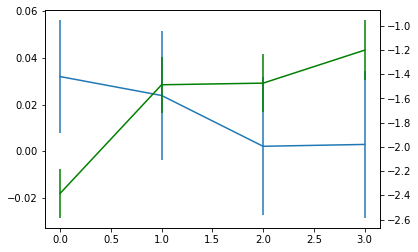

In [141]:

ma_common = #np.ones(data.shape[0],dtype=bool)#(data['pyr_1']>pyr_thresh)#np.ones(data.shape[0],dtype=bool)#(data['pyr_1']>pyr_thresh)&(data['pyr_2']>pyr_thresh)#
# ma_group_l = [(data['selected_int_1'] <-int_thresh)&(data['selected_int_2'] >int_thresh),
#               (data['selected_int_1'] >int_thresh)&(data['selected_int_2'] >int_thresh)
# ]

# ma_group_l = [(data['selected_int_1'] <-int_thresh)&(data['selected_int_2'] <-int_thresh),
#               (data['selected_int_1'] >int_thresh)&(data['selected_int_2'] <-int_thresh)
# ]
ma_group_l = [(data['selected_int_1'] <-int_thresh),
              (data['selected_int_1'] >int_thresh)
]


neuron_type = 'pyr'
pyr_diff_l,pyr_ci_l = filter_tick_group_get_diff_ci(data,ma_common,ma_group_l,doplot=False,neuron_type=neuron_type)

neuron_type = 'int'
int_diff_l,int_ci_l = filter_tick_group_get_diff_ci(data,ma_common,ma_group_l,doplot=False,neuron_type=neuron_type)


fig,ax=plt.subplots()
ax.errorbar(np.arange(len(pyr_diff_l)),pyr_diff_l,yerr=np.abs(pyr_ci_l-pyr_diff_l[None,:]))
ax2=ax.twinx()
ax2.errorbar(np.arange(len(int_diff_l)),int_diff_l,yerr=np.abs(int_ci_l-int_diff_l[None,:]),c='green')

In [140]:
data_with_sw=data.query('has_sw_on')

inh  selected_inh     pyr_1  \
e13_26m1 e13_26m1_210913 0.0  3  0 14  2.059459      0.532958  0.275181   
                              34 2 20  4.233693      2.562666  0.952668   
                              36 2 7   0.495035      0.654418  0.626772   
                              37 0 3  -0.596802     -1.914947  0.734287   
                                 1 11  3.819482      3.179275  0.793271   
...                                         ...           ...       ...   
e14_2m3  e14_2m3_201118  both 3  0 1   2.552786      1.440983  0.719934   
                              22 0 2  -2.728990      1.456213  0.381028   
                              26 0 13  5.549886      0.000000  0.809733   
                              27 0 1   6.174131      7.860108  0.758046   
                              28 0 5  -0.059964     -7.712942  0.408811   

                                          pyr_2     pyr_3     pyr_4     int_1  \
e13_26m1 e13_26m1_210913 0.0  3  0 14  0.785383  0.452757  0.779819  2.059459   
                              34 2 20  0.525244  0.000324  0.655585  4.233693   
                              36 2 7   0.665661  0.334438  0.460286  0.495035   
                              37 0 3   0.239889  0.374760  0.653224 -0.596802   
                                 1 11  0.591578  0.588534  0.401005  3.819482   
...                                         ...       ...       ...       ...   
e14_2m3  e14_2m3_201118  both 3  0 1   0.905632  0.648556  0.347496  2.552786   
                              22 0 2   0.080829  0.501534  0.570970 -2.728990   
                              26 0 13  0.811738  0.464803  0.372107  5.549886   
                              27 0 1   0.849763  0.565122  0.555909  6.174131   
                              28 0 5   0.514716  0.325704 -0.183069 -0.059964   

                                          int_2     int_3     int_4  \
e13_26m1 e13_26m1_210913 0.0  3  0 14  1.359561  0.170006  2.017204   
                              34 2 20  3.506090  5.095343  4.125808   
                              36 2 7   0.899719 -0.481629 -0.964169   
                              37 0 3  -1.256256 -2.215221 -3.428851   
                                 1 11  3.059694  5.096867  4.348979   
...                                         ...       ...       ...   
e14_2m3  e14_2m3_201118  both 3  0 1  -0.200767  2.423307  4.478405   
                              22 0 2  -8.057367 -2.768677 -2.343906   
                              26 0 13  2.046623  1.830507  0.945155   
                              27 0 1   3.812472  1.746545  5.588004   
                              28 0 5  -5.030362 -7.305679 -7.957392   

                                       selected_int_1  selected_int_2  \
e13_26m1 e13_26m1_210913 0.0  3  0 14        0.532958        1.076230   
                              34 2 20        2.562666        6.163836   
                              36 2 7         0.654418        1.096300   
                              37 0 3        -1.914947       -2.659510   
                                 1 11        3.179275        3.089071   
...                                               ...             ...   
e14_2m3  e14_2m3_201118  both 3  0 1         1.440983        6.335089   
                              22 0 2         1.456213        1.298319   
                              26 0 13        0.000000        0.000000   
                              27 0 1         7.860108       11.732592   
                              28 0 5        -7.712942       -4.415080   

                                       selected_int_3  selected_int_4  \
e13_26m1 e13_26m1_210913 0.0  3  0 14       -3.694629       -1.743365   
                              34 2 20       13.947636        6.482740   
                              36 2 7         0.266978       -1.115282   
                              37 0 3        -3.002320       -4.623252   
                                 1 11        4.555342        4.562006   
..

In [110]:
def filter_tick_group_inh_get_diff_ci(data,ma_updown,int_thresh=0,doplot=False,neuron_type='pyr'):
    ma = ma_updown & (data[inh_key] < -int_thresh)
    pyr_disinh=data.loc[ma].loc[:,f'{neuron_type}_1':f'{neuron_type}_4']
    # fig,ax=ph.mean_across_row_vs_col_with_err(toplot,label='disinhibition',fig=fig,ax=ax,color='red',**kwargs)
    ma = ma_updown & (data[inh_key] > int_thresh)
    pyr_inh=data.loc[ma].loc[:,f'{neuron_type}_1':f'{neuron_type}_4']
    # fig,ax=ph.mean_across_row_vs_col_with_err(toplot,label='more inhibition',fig=fig,ax=ax,color='blue',**kwargs)
    
    t_l = []
    p_l = []
    ci_l = []
    diff_l = []
    for k in pyr_disinh.columns:
        X1=pyr_disinh[k].dropna()
        X2=pyr_inh[k].dropna()
        cm=sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
        ci = cm.tconfint_diff()
    #     t,p,_ = cm.ttest_ind()
        diff = np.mean(ci)
        diff_l.append(diff)
        t_l.append(t)
        p_l.append(p)
        ci_l.append(ci)
    diff_l = np.array(diff_l)
    ci_l =np.array(ci_l).T
    if doplot:
        fig,ax=plt.subplots()
        ax.errorbar(np.arange(len(diff_l)),diff_l,yerr=np.abs(ci_l-diff_l[None,:]))
    
    return diff_l,ci_l


In [112]:
updown='Uptick'
ma_updown = ma_updown_d[updown]
nt = 'pyr'
pyr_diff_l,pyr_ci_l = filter_tick_group_inh_get_diff_ci(data,ma_updown,int_thresh=0,doplot=False,neuron_type=nt)
nt = 'int'
int_diff_l,int_ci_l = filter_tick_group_inh_get_diff_ci(data,ma_updown,int_thresh=0,doplot=False,neuron_type=nt)

<ErrorbarContainer object of 3 artists>

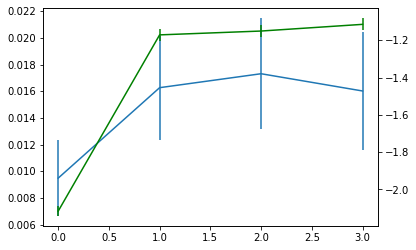

In [116]:
fig,ax=plt.subplots()
ax.errorbar(np.arange(len(pyr_diff_l)),pyr_diff_l,yerr=np.abs(pyr_ci_l-pyr_diff_l[None,:]))
ax2=ax.twinx()
ax2.errorbar(np.arange(len(int_diff_l)),int_diff_l,yerr=np.abs(int_ci_l-int_diff_l[None,:]),c='green')

<ErrorbarContainer object of 3 artists>

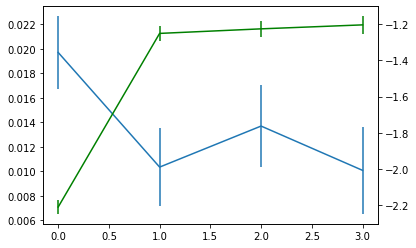

In [117]:
updown='Uptick'
ma_updown = np.ones(data.shape[0],dtype=bool)
nt = 'pyr'
pyr_diff_l,pyr_ci_l = filter_tick_group_inh_get_diff_ci(data,ma_updown,int_thresh=0,doplot=False,neuron_type=nt)
nt = 'int'
int_diff_l,int_ci_l = filter_tick_group_inh_get_diff_ci(data,ma_updown,int_thresh=0,doplot=False,neuron_type=nt)

fig,ax=plt.subplots()
ax.errorbar(np.arange(len(pyr_diff_l)),pyr_diff_l,yerr=np.abs(pyr_ci_l-pyr_diff_l[None,:]))
ax2=ax.twinx()
ax2.errorbar(np.arange(len(int_diff_l)),int_diff_l,yerr=np.abs(int_ci_l-int_diff_l[None,:]),c='green')

In [113]:
pyr_diff_l

array([0.00949072, 0.0162679 , 0.01731197, 0.01601978])

In [67]:
updown='Uptick'
ma_updown = ma_updown_d[updown]
ma = ma_updown & (data[inh_key] < -int_thresh)

pyr_disinh=data.loc[ma].loc[:,'pyr_1':'pyr_4']
# fig,ax=ph.mean_across_row_vs_col_with_err(toplot,label='disinhibition',fig=fig,ax=ax,color='red',**kwargs)
ma = ma_updown & (data[inh_key] > int_thresh)
pyr_inh=data.loc[ma].loc[:,'pyr_1':'pyr_4']
# fig,ax=ph.mean_across_row_vs_col_with_err(toplot,label='more inhibition',fig=fig,ax=ax,color='blue',**kwargs)



<ErrorbarContainer object of 3 artists>

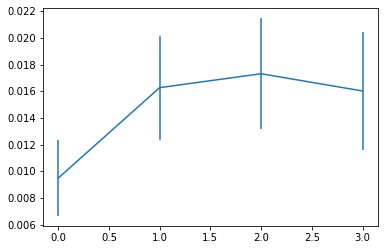

In [107]:
t_l = []
p_l = []
ci_l = []
diff_l = []
for k in pyr_disinh.columns:
    X1=pyr_disinh[k].dropna()
    X2=pyr_inh[k].dropna()
    cm=sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
    ci = cm.tconfint_diff()
#     t,p,_ = cm.ttest_ind()
    diff = np.mean(ci)
    diff_l.append(diff)
    t_l.append(t)
    p_l.append(p)
    ci_l.append(ci)
diff_l = np.array(diff_l)
ci_l =np.array(ci_l).T
fig,ax=plt.subplots()
ax.errorbar(np.arange(len(diff_l)),diff_l,yerr=np.abs(ci_l-diff_l[None,:]))

In [65]:
ma

e13_26m1  e13_26m1_210913  0.0   3   0  0      True
                                        1     False
                                        2     False
                                        3     False
                                        4     False
                                              ...  
e14_2m3   e14_2m3_201118   both  53  0  19    False
                                        20    False
                                        21     True
                                        22    False
                                        23    False
Length: 202145, dtype: bool

# uptick that turn into switch vs not, amplitude matched, delta_int

In [269]:
pyr_thresh=0.8
ma_common = (data['pyr_1'] >pyr_thresh) & (data['field_has_sw_on']) 
ma_group_l = [data['has_sw_on'],np.logical_not(data['has_sw_on'])]
val_l = []
pyr_1_l=[]
data_grouped_l = []
inh_key = 'selected_inh'
for ma_group in ma_group_l:
    ma = ma_common & ma_group
    data_grouped_l.append(data.loc[ma])
    val = data.loc[ma][inh_key]
    
    pyr_1_l.append(data.loc[ma]['pyr_1'])
    val_l.append(val)

In [266]:
scipy.stats.ranksums(pyr_1_l[0],pyr_1_l[1])

RanksumsResult(statistic=0.8252846937844313, pvalue=0.40920997958963035)

(None, <Axes: xlabel='Trial', ylabel='value'>)

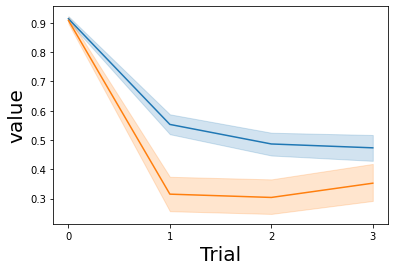

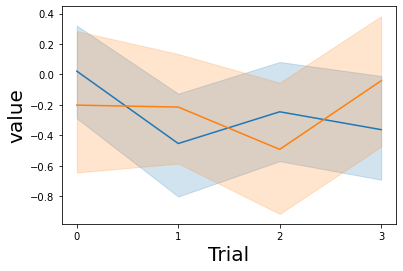

In [276]:
fig,ax=plt.subplots()
ph.mean_across_row_vs_col_with_err(data_grouped_l[0].loc[:,'pyr_1':'pyr_4'],ax=ax)
ph.mean_across_row_vs_col_with_err(data_grouped_l[1].loc[:,'pyr_1':'pyr_4'],ax=ax)

fig,ax=plt.subplots()
inh_key='int'
ph.mean_across_row_vs_col_with_err(data_grouped_l[0].loc[:,f'{inh_key}_1':f'{inh_key}_4'],ax=ax)
ph.mean_across_row_vs_col_with_err(data_grouped_l[1].loc[:,f'{inh_key}_1':f'{inh_key}_4'],ax=ax)

In [267]:
pyr_1_l

[e13_26m1  e13_26m1_210913  0.0   34   2  20    0.952668
                                  136  0  3     0.801398
                                  153  0  15    0.895154
                                  158  1  12    1.000000
                                  163  0  24    1.000000
                                                  ...   
 e14_2m3   e14_2m3_201121   1.0   51   0  7     1.000000
                            both  49   0  8     1.000000
           e14_2m3_201118   0.0   35   0  8     1.000000
                            1.0   23   1  2     0.808948
                            both  26   0  13    0.809733
 Name: pyr_1, Length: 271, dtype: float64,
 e13_26m1  e13_26m1_210913  0.0   34   2  26    0.985861
                                  116  2  18    1.000000
                                  118  1  4     0.893884
                                  153  0  28    0.944545
                                  154  2  15    0.837169
                                             

In [268]:
scipy.stats.ranksums(val_l[0],val_l[1])

RanksumsResult(statistic=-1.0094008978910476, pvalue=0.31278240801883483)

In [244]:
data.loc[ma]['pyr_1']

e13_26m1  e13_26m1_210913  0.0   3   0  0     0.565348
                                        3     0.157642
                                        8     0.326394
                                        9     0.184653
                                        13    0.214617
                                                ...   
e14_2m3   e14_2m3_201118   both  28  0  13    0.398815
                                        16    0.247156
                                        18    0.238819
                                        20    0.234796
                                        21    0.310996
Name: pyr_1, Length: 7523, dtype: float64

In [241]:
val_l[0]

e13_26m1  e13_26m1_210913  0.0   3   0  14    0.532958
                                 34  2  20    2.562666
                                 36  2  7     0.654418
                                 37  0  3    -1.914947
                                     1  11    3.179275
                                                ...   
e14_2m3   e14_2m3_201118   both  3   0  1     1.440983
                                 22  0  2     1.456213
                                 26  0  13    0.000000
                                 27  0  1     7.860108
                                 28  0  5    -7.712942
Name: selected_inh, Length: 1401, dtype: float64

In [242]:
scipy.stats.ranksums(val_l[0],val_l[1])

RanksumsResult(statistic=-1.9224924295115655, pvalue=0.05454382527281673)

# proportion of uptick that turn into switch

In [170]:
data['has_uptick'] = data['pyr_1'] > pyr_thresh

In [184]:
pyr_thresh = 0.3
inh_thresh = 0
inh_key = 'selected_inh'
ma = (data['pyr_1']>pyr_thresh) & (data[inh_key] < -inh_thresh) &(data['field_has_sw_on'])
# ma =  (data[inh_key] < -inh_thresh)
xx=data.loc[ma]['has_sw_on']
ma = (data['pyr_1']>pyr_thresh) & (data[inh_key] > inh_thresh) &(data['field_has_sw_on'])
# ma =  (data[inh_key] > inh_thresh)
yy=data.loc[ma]['has_sw_on']

count=np.array([xx.sum(),yy.sum()])
nobs=np.array([len(xx),len(yy)])
print(proportions_ztest(count,nobs))

(2.150959702365798, 0.03147938052046597)


In [186]:
xx.sum()

746

In [187]:
yy.sum()

596

In [86]:
data

inh  selected_inh     pyr_1  \
e13_26m1 e13_26m1_210913 0.0  3  0 0  -0.189098     -1.275752  0.565348   
                                   1   0.130961     -0.062743 -0.583429   
                                   2   0.037897     -0.864214 -0.384418   
                                   3   0.907485      1.158292  0.157642   
                                   4  -2.302433     -4.455275 -0.157642   
...                                         ...           ...       ...   
e14_2m3  e14_2m3_201118  both 53 0 19  0.631108     -0.701710 -0.278657   
                                   20  4.037379      9.155352  0.057108   
                                   21 -2.951633     -9.236129  0.097137   
                                   22 -6.839295    -14.978466 -0.161459   
                                   23       NaN           NaN       NaN   

                                          pyr_2     pyr_3     pyr_4     int_1  \
e13_26m1 e13_26m1_210913 0.0  3  0 0  -0.018081 -0.402499 -0.244857 -0.189098   
                                   1  -0.967846 -0.810205 -0.967846  0.130961   
                                   2  -0.226776 -0.384418 -0.384418  0.037897   
                                   3   0.000000  0.000000  0.000000  0.907485   
                                   4  -0.157642 -0.157642 -0.157642 -2.302433   
...                                         ...       ...       ...       ...   
e14_2m3  e14_2m3_201118  both 53 0 19 -0.221549 -0.124412 -0.285871  0.631108   
                                   20  0.154245 -0.007214       NaN  4.037379   
                                   21 -0.064322       NaN       NaN -2.951633   
                                   22       NaN       NaN       NaN -6.839295   
                                   23       NaN       NaN       NaN       NaN   

                                          int_2     int_3     int_4  \
e13_26m1 e13_26m1_210913 0.0  3  0 0  -0.058137 -0.020240  0.887246   
                                   1   0.168858  1.076344 -1.226089   
                                   2   0.945383 -1.357050 -0.097108   
                                   3  -1.394947 -0.135005  0.868624   
                                   4  -1.042491 -0.038861 -1.506386   
...                                         ...       ...       ...   
e14_2m3  e14_2m3_201118  both 53 0 19  4.668487  1.716854 -5.122441   
                                   20  1.085746 -5.753549       NaN   
                                   21 -9.790929       NaN       NaN   
                                   22       NaN       NaN       NaN   
                                   23       NaN       NaN       NaN   

                                       selected_int_1  selected_int_2  \
e13_26m1 e13_26m1_210913 0.0  3  0 0        -1.275752       -1.338495   
                                   1        -0.062743       -0.926957   
                                   2        -0.864214        0.294078   
                                   3         1.158292       -3.296983   
                                   4        -4.455275       -1.124007   
...                                               ...             ...   
e14_2m3  e14_2m3_201118  both 53 0 19       -0.701710        8.453641   
                                   20        9.155352       -0.080777   
                                   21       -9.236129      -24.214594   
                                   22      -14.978466             NaN   
                                   23             NaN             NaN   

                                       selected_int_3  selected_int_4  \
e13_26m1 e13_26m1_210913 0.0  3  0 0        -2.202709       -1.044417   
                                   1         0.231335       -4.223940   
                                   2        -4.161196       -0.829929   
                                   3         0.034285       -0.423471   
                                   4        -1.581762       -2.917308   
..

In [23]:
def sweep_inh_thresh_get_p_sw_given_tick_grouped_by_disinhibition(data,inh_thresh_l=[0.,1.,3.,6.],inh_key='selected_inh',onoff_key='on',pyr_thresh=0.):
    '''
    data: consec_trial_fr_diff_all with has_sw
    '''
    has_sw_given_tick_df_d = {}
    z_d={}
    p_d={}
    for inh_thresh in inh_thresh_l:
        has_sw_given_tick_df, z, p = get_p_sw_given_tick_grouped_by_disinhibition(data,inh_thresh=inh_thresh,pyr_thresh=pyr_thresh,inh_key=inh_key,onoff_key=onoff_key)
        has_sw_given_tick_df_d[inh_thresh] = has_sw_given_tick_df
        z_d[inh_thresh] = z
        p_d[inh_thresh] = p
    has_sw_given_tick_df_d = pd.concat(has_sw_given_tick_df_d,axis=0)
    z_d = pd.Series(z_d)
    p_d=pd.Series(p_d)
    
    has_sw_given_tick_df_d=has_sw_given_tick_df_d.reset_index(level=(0)).rename({'level_0':'inh_thresh'},axis=1).reset_index(drop=True)
    
    return has_sw_given_tick_df_d,z_d, p_d
        
        
    

def get_p_sw_given_tick_grouped_by_disinhibition(data,inh_thresh=0.,pyr_thresh=0.,inh_key='selected_inh',onoff_key='on'):
    sw_key = f'has_sw_{onoff_key}'#'has_sw_off'
    
    if onoff_key=='on':
        tick_ma = data['pyr_1'] > pyr_thresh
    else:
        tick_ma = data['pyr_1'] < -pyr_thresh

    # ma=(data['pyr_1']>pyr_thresh) & (data['inh']<-inh_thresh)
    ma= (data[inh_key]<-inh_thresh) & tick_ma
    xx=data.loc[ma][sw_key].reset_index(drop=True)

    # ma=(data['pyr_1']>pyr_thresh) & (data['inh']>inh_thresh)
    ma= (data[inh_key]>inh_thresh) & tick_ma
    yy=data.loc[ma][sw_key].reset_index(drop=True)
    
    has_sw_given_tick_df=pd.concat({'disinhibition':xx,'more inhibition':yy},axis=0)
    
    count=np.array([xx.sum(),yy.sum()])
    nobs=np.array([len(xx),len(yy)])

    z,p=proportions_ztest(count,nobs)
    has_sw_given_tick_df=has_sw_given_tick_df.reset_index(level=0).rename({'level_0':'inh_type'},axis=1).reset_index(drop=True)

    
    
    return has_sw_given_tick_df, z, p
    
    

In [48]:
def sweep_inh_thresh_get_p_tick_grouped_by_disinhibition(data,inh_thresh_l=[0.,1.,3.,6.],inh_key='selected_inh',tick_key='uptick',pyr_thresh=0.):
    '''
    data: consec_trial_fr_diff_all with has_sw
    '''
    has_tick_df_d = {}
    z_d={}
    p_d={}
    for inh_thresh in inh_thresh_l:
        has_tick_df, z, p = get_p_tick_grouped_by_disinhibition(data,inh_thresh=inh_thresh,pyr_thresh=pyr_thresh,inh_key=inh_key,tick_key=tick_key)
        has_tick_df_d[inh_thresh] = has_tick_df
        z_d[inh_thresh] = z
        p_d[inh_thresh] = p
    has_tick_df_d = pd.concat(has_tick_df_d,axis=0)
    z_d = pd.Series(z_d)
    p_d=pd.Series(p_d)
    
    has_tick_df_d=has_tick_df_d.reset_index(level=(0)).rename({'level_0':'inh_thresh'},axis=1).reset_index(drop=True)
    
    return has_tick_df_d,z_d, p_d

def get_p_tick_grouped_by_disinhibition(data,inh_thresh=0.,pyr_thresh=0.,tick_key = 'uptick',inh_key='selected_inh'):

    
    ma_dis= data[inh_key]<-inh_thresh
    ma_inh = data[inh_key] > inh_thresh
    if tick_key=='uptick':
        xx = data.loc[ma_dis]['pyr_1']>pyr_thresh
        yy = data.loc[ma_inh]['pyr_1']>pyr_thresh
    else:
        xx = data.loc[ma_dis]['pyr_1']<-pyr_thresh
        yy = data.loc[ma_inh]['pyr_1']<-pyr_thresh
    xx = xx.reset_index(drop=True)
    yy = yy.reset_index(drop=True)
    
    has_tick_df=pd.concat({'disinhibition':xx,'more inhibition':yy},axis=0)
    
    count=np.array([xx.sum(),yy.sum()])
    nobs=np.array([len(xx),len(yy)])

    z,p=proportions_ztest(count,nobs)
    has_tick_df=has_tick_df.reset_index(level=0).rename({'level_0':'inh_type'},axis=1).reset_index(drop=True)
    return has_tick_df,z,p
    

In [37]:
has_tick_df,z,p = get_p_tick_grouped_by_disinhibition(data,inh_thresh=0.,pyr_thresh=0.,tick_key = 'uptick',inh_key='selected_inh')



In [38]:
has_tick_df

,inh_type,pyr_1
0,disinhibition,True
1,disinhibition,False
2,disinhibition,False
3,disinhibition,False
4,disinhibition,False
...,...,...
178065,more inhibition,False
178066,more inhibition,True
178067,more inhibition,False
178068,more inhibition,False


In [50]:
has_tick_df_d

,inh_thresh,inh_type,pyr_1
0,0,disinhibition,True
1,0,disinhibition,False
2,0,disinhibition,False
3,0,disinhibition,False
4,0,disinhibition,False
...,...,...,...
426407,6,more inhibition,False
426408,6,more inhibition,True
426409,6,more inhibition,False
426410,6,more inhibition,False


on
0    0.125268
1    0.197492
2    0.218036
3    0.112995
4    0.003617
5    0.010177
6    0.035829
dtype: float64
off
0    0.001542
1    0.000011
2    0.000111
3    0.000044
4    0.000262
5    0.003404
6    0.014221
dtype: float64


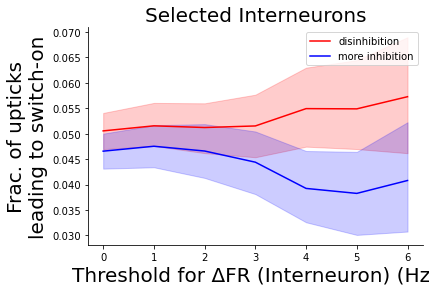

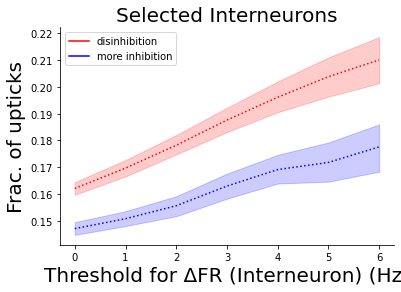

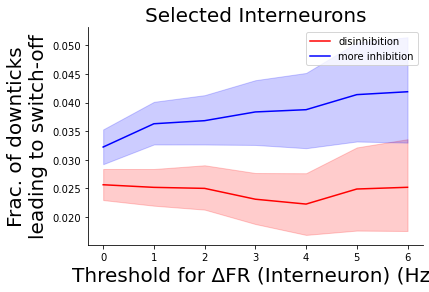

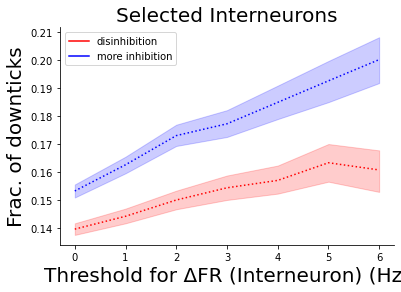

In [60]:
from statsmodels.stats.proportion import proportions_ztest
inh_thresh_l = [0,1,2,3,4,5,6]
pyr_thresh = 0.3
inh_key = 'selected_inh'
title='Selected Interneurons'
tickkey_d = {'on':'uptick','off':'downtick'}
savefig=False
for onoff_key in ['on','off']:
    has_sw_given_tick_df_d,z_d, p_d = sweep_inh_thresh_get_p_sw_given_tick_grouped_by_disinhibition(data,inh_thresh_l=inh_thresh_l,inh_key=inh_key,onoff_key=onoff_key,pyr_thresh=pyr_thresh)
    print(onoff_key)
    print(p_d)
    fig,ax=plt.subplots()
    hue_order = ['disinhibition','more inhibition']
    ax=sns.lineplot(data=has_sw_given_tick_df_d,x='inh_thresh',y=f'has_sw_{onoff_key}',hue='inh_type',ax=ax,hue_order=hue_order,palette=['red','blue'])
    tickkey=tickkey_d[onoff_key] 
    ax.set_ylabel(f'Frac. of {tickkey}s\nleading to switch-{onoff_key}')
    ax.set_xlabel(u'Threshold for ΔFR (Interneuron) (Hz)')
    ax.get_legend().set_title(None)
    ax.set_title(title)
    sns.despine()
    if savefig:
        figfn = f'frac_leading_switch_{onoff_key}_vs_{inh_key}_thresh.svg'
        fig.savefig(os.path.join(figdir,figfn),bbox_inches='tight')
        figfn = f'frac_leading_switch_{onoff_key}_vs_{inh_key}_thresh.png'
        fig.savefig(os.path.join(figdir,figfn),bbox_inches='tight')
    
    fig,ax=plt.subplots()
    has_tick_df_d,z_d, p_d = sweep_inh_thresh_get_p_tick_grouped_by_disinhibition(data,inh_thresh_l=inh_thresh_l,inh_key=inh_key,tick_key=tickkey,pyr_thresh=pyr_thresh)
#     fig,ax=plt.subplots()
    ax=sns.lineplot(data=has_tick_df_d,x='inh_thresh',y='pyr_1',hue='inh_type',ax=ax,palette=['red','blue'],linestyle=':')
    ax.set_ylabel(f'Frac. of {tickkey}s')
    ax.set_xlabel(u'Threshold for ΔFR (Interneuron) (Hz)')
    ax.get_legend().set_title(None)
    ax.set_title(title)
    sns.despine()
    if savefig:
        figfn = f'frac_{tickkey}_vs_{inh_key}_thresh.svg'
        fig.savefig(os.path.join(figdir,figfn),bbox_inches='tight')
        figfn = f'frac_{tickkey}_vs_{inh_key}_thresh.png'
        fig.savefig(os.path.join(figdir,figfn),bbox_inches='tight')
    

on
0    0.156047
1    0.041806
2    0.171252
3    0.386483
4    0.144078
5    0.251116
6    0.659383
dtype: float64
off
0    0.042224
1    0.049836
2    0.054784
3    0.009556
4    0.131839
5    0.085511
6    0.141449
dtype: float64


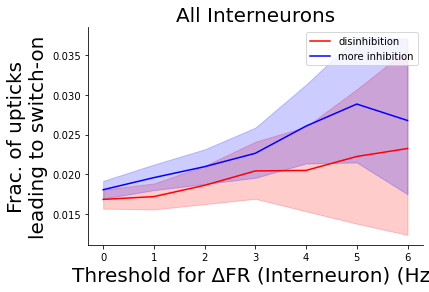

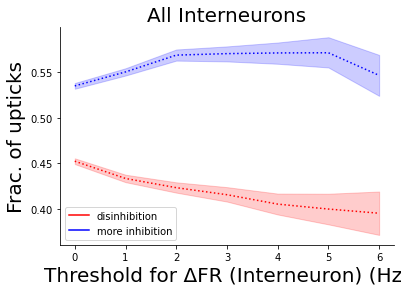

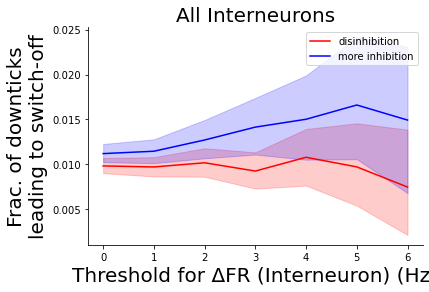

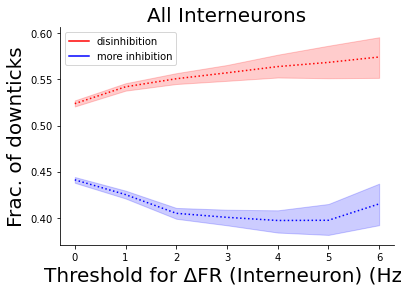

In [59]:
from statsmodels.stats.proportion import proportions_ztest
inh_thresh_l = [0,1,2,3,4,5,6]
pyr_thresh = 0.0
inh_key = 'inh'
title='All Interneurons'
tickkey_d = {'on':'uptick','off':'downtick'}
for onoff_key in ['on','off']:
    has_sw_given_tick_df_d,z_d, p_d = sweep_inh_thresh_get_p_sw_given_tick_grouped_by_disinhibition(data,inh_thresh_l=inh_thresh_l,inh_key=inh_key,onoff_key=onoff_key,pyr_thresh=pyr_thresh)
    print(onoff_key)
    print(p_d)
    fig,ax=plt.subplots()
    hue_order = ['disinhibition','more inhibition']
    ax=sns.lineplot(data=has_sw_given_tick_df_d,x='inh_thresh',y=f'has_sw_{onoff_key}',hue='inh_type',ax=ax,hue_order=hue_order,palette=['red','blue'])
    tickkey=tickkey_d[onoff_key] 
    ax.set_ylabel(f'Frac. of {tickkey}s\nleading to switch-{onoff_key}')
    ax.set_xlabel(u'Threshold for ΔFR (Interneuron) (Hz)')
    ax.get_legend().set_title(None)
    ax.set_title(title)
    sns.despine()
    figfn = f'frac_leading_switch_{onoff_key}_vs_{inh_key}_thresh.svg'
    fig.savefig(os.path.join(figdir,figfn),bbox_inches='tight')
    figfn = f'frac_leading_switch_{onoff_key}_vs_{inh_key}_thresh.png'
    fig.savefig(os.path.join(figdir,figfn),bbox_inches='tight')
    
    fig,ax=plt.subplots()
    has_tick_df_d,z_d, p_d = sweep_inh_thresh_get_p_tick_grouped_by_disinhibition(data,inh_thresh_l=inh_thresh_l,inh_key=inh_key,tick_key=tickkey,pyr_thresh=pyr_thresh)
#     fig,ax=plt.subplots()
    ax=sns.lineplot(data=has_tick_df_d,x='inh_thresh',y='pyr_1',hue='inh_type',ax=ax,palette=['red','blue'],linestyle=':')
    ax.set_ylabel(f'Frac. of {tickkey}s')
    ax.set_xlabel(u'Threshold for ΔFR (Interneuron) (Hz)')
    ax.get_legend().set_title(None)
    ax.set_title(title)
    sns.despine()
    figfn = f'frac_{tickkey}_vs_{inh_key}_thresh.svg'
    fig.savefig(os.path.join(figdir,figfn),bbox_inches='tight')
    figfn = f'frac_{tickkey}_vs_{inh_key}_thresh.png'
    fig.savefig(os.path.join(figdir,figfn),bbox_inches='tight')
    

off
0    1.223910e-05
1    2.739800e-09
3    4.099714e-07
4    1.247776e-06
5    3.922425e-05
6    2.620523e-04
dtype: float64


Text(0, 0.5, 'Frac. of downticks\nleading to switch-off')

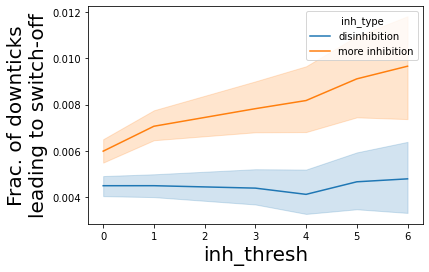

In [24]:
pyr_thresh = None
has_sw_given_tick_df_d,z_d, p_d = sweep_inh_thresh_get_p_sw_given_tick_grouped_by_disinhibition(data,inh_thresh_l=inh_thresh_l,inh_key='selected_inh',onoff_key=onoff_key,pyr_thresh=pyr_thresh)
print(onoff_key)
print(p_d)
fig,ax=plt.subplots()
ax=sns.lineplot(data=has_sw_given_tick_df_d,x='inh_thresh',y=f'has_sw_{onoff_key}',hue='inh_type',ax=ax)
tickkey=tickkey_d[onoff_key] 
ax.set_ylabel(f'Frac. of {tickkey}s\nleading to switch-{onoff_key}')

0    0.024547
1    0.073879
3    0.048700
4    0.003667
5    0.002856
6    0.020213
dtype: float64

Text(0, 0.5, 'Frac. of upticks\nleading to switch-on')

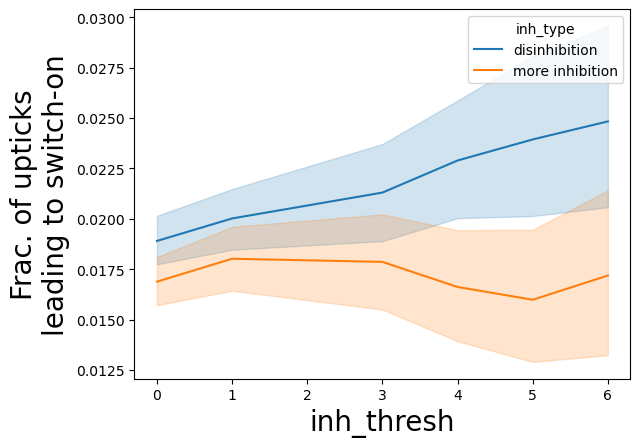

In [133]:
ax=sns.lineplot(data=has_sw_given_tick_df_d,x='inh_thresh',y='has_sw_on',hue='inh_type')
ax.set_ylabel('Frac. of upticks\nleading to switch-on')

In [ ]:
ax=sns.lineplot(data=has_sw_given_tick_df_d,x='inh_thresh',y='has_sw_off',hue='inh_type')
ax.set_ylabel('Frac. of downticks\nleading to switch-on')

In [98]:
has_sw_given_tick_df.reset_index(level=(0,1)).rename({'level_0':'inh_thresh','level_1':'inh_type'},axis=1)

,inh_thresh,inh_type,has_sw_on
0,0,disinhibition,False
1,0,disinhibition,False
2,0,disinhibition,False
3,0,disinhibition,False
4,0,disinhibition,False
...,...,...,...
3544,6,more inhibition,False
3545,6,more inhibition,False
3546,6,more inhibition,False
3547,6,more inhibition,False


In [90]:
has_sw_given_tick_df=get_p_sw_given_tick_grouped_by_disinhibition(data,inh_thresh=0.,pyr_thresh=0.,inh_key='selected_inh',onoff_key='on')



In [91]:
has_sw_given_tick_df

disinhibition    0        False
                 1        False
                 2        False
                 3        False
                 4        False
                          ...  
more inhibition  41984    False
                 41985    False
                 41986    False
                 41987    False
                 41988    False
Name: has_sw_on, Length: 87697, dtype: bool

In [88]:
xx.reset_index(drop=True)

0       False
1       False
2       False
3       False
4       False
        ...  
5283    False
5284    False
5285    False
5286    False
5287    False
Name: has_sw_off, Length: 5288, dtype: bool

(-0.4407654986292164, 0.6593827732236524)
(-1.4704161487505059, 0.14144908033930967)
(2.072639105579604, 0.03820587881301601)
(-3.341579296607454, 0.0008330321781871101)


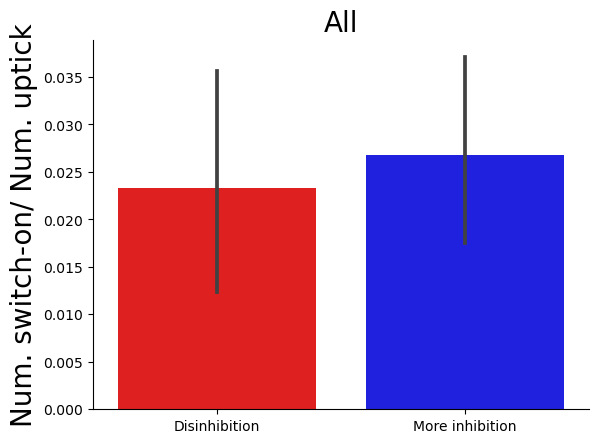

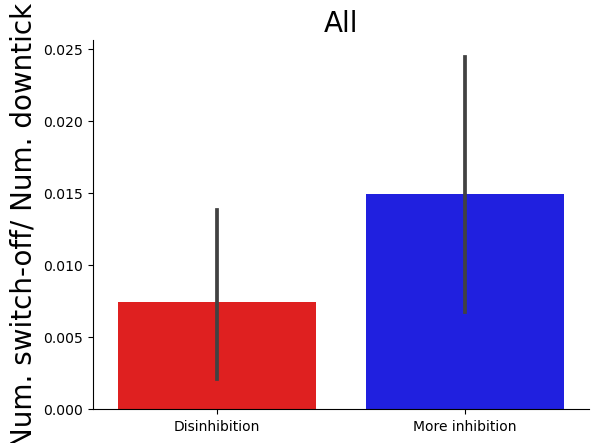

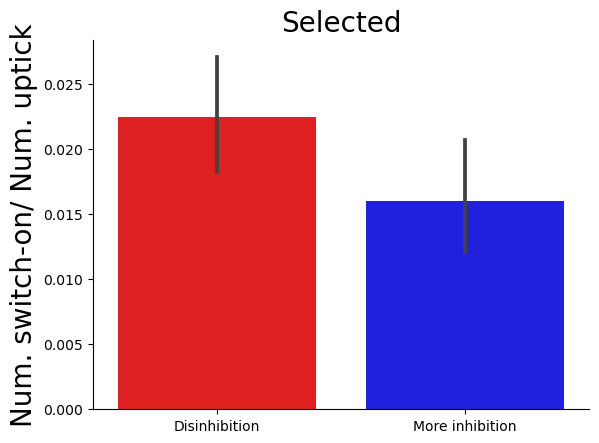

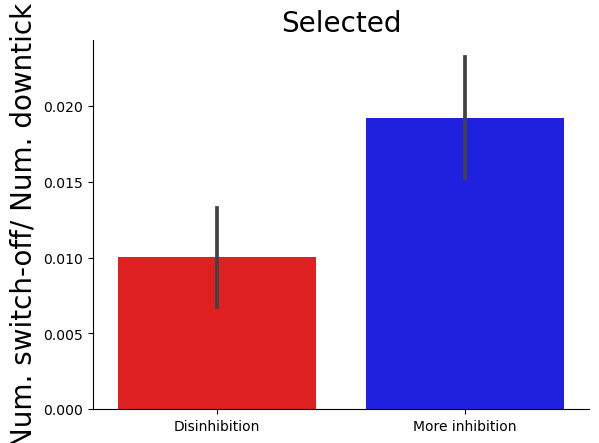

In [126]:

pyr_thresh = 0.
inh_thresh = 6.#0


for inh_key in ['inh','selected_inh']:
# inh_key = 'inh'#'selected_inh'
    for onoff_key in ['on','off']:

        sw_key = f'has_sw_{onoff_key}'#'has_sw_off'
        if onoff_key=='on':
            tick_ma = data['pyr_1'] > pyr_thresh
        else:
            tick_ma = data['pyr_1'] < -pyr_thresh


        # ma=(data['pyr_1']>pyr_thresh) & (data['inh']<-inh_thresh)
        ma= (data[inh_key]<-inh_thresh) & tick_ma
        xx=data.loc[ma][sw_key]

        # ma=(data['pyr_1']>pyr_thresh) & (data['inh']>inh_thresh)
        ma= (data[inh_key]>inh_thresh) & tick_ma
        yy=data.loc[ma][sw_key]

        count=np.array([xx.sum(),yy.sum()])
        nobs=np.array([len(xx),len(yy)])

        print(proportions_ztest(count,nobs))

        data['has_disinh_and_tick'] = np.nan
        data.loc[(data[inh_key] < -inh_thresh)&tick_ma,'has_disinh_and_tick'] = True
        data.loc[(data[inh_key] >  inh_thresh)&tick_ma,'has_disinh_and_tick'] = False

        fig,ax=plt.subplots()
        sns.barplot(x='has_disinh_and_tick', y=sw_key, data=data.loc[data['has_disinh_and_tick'].notna()],order=[True,False],palette=['red','blue'],ax=ax)
        sns.despine()

        tickkey_d ={'on':'up','off':'down'}
        tickkey =tickkey_d[onoff_key]
        ylabel = f'Num. switch-{onoff_key}/ Num. {tickkey}tick'
        title_dict = {'inh':'All','selected_inh':'Selected'}
        title=title_dict[inh_key]
        ax.set(ylabel=ylabel,xlabel='',title=title)
        xticklabels=['Disinhibition','More inhibition']
        ax.set_xticklabels(xticklabels)

[Text(0, 0, 'Disinhibition'), Text(1, 0, 'More inhibition')]

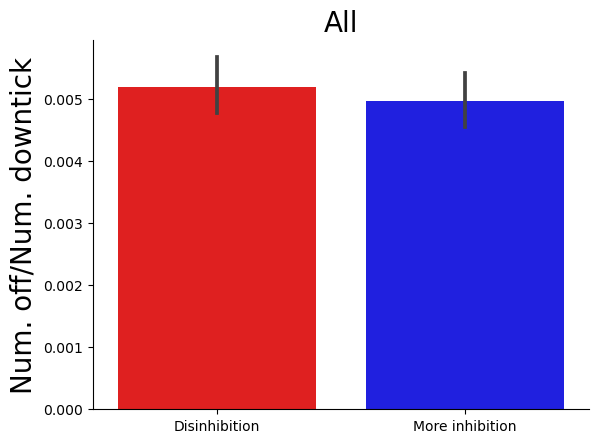

<Axes: xlabel='has_selected_disinh', ylabel='has_sw_on'>

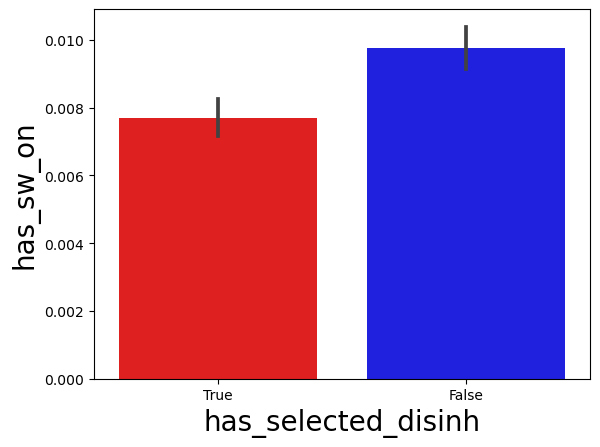

In [32]:
sns.barplot(x='has_selected_disinh',y='has_sw_on',data=data,order=[True,False],palette=['red','blue'])

In [59]:
# proportion of uptick that turns into switch
from statsmodels.stats.proportion import proportions_ztest
pyr_thresh = 0.
inh_thresh = 0
inh_key = 'selected_inh'#'inh'
sw_key = 'has_sw_on'#'has_sw_off'
# ma=(data['pyr_1']>pyr_thresh) & (data['inh']<-inh_thresh)
ma= (data[inh_key]<-inh_thresh)
xx=data.loc[ma][sw_key]

# ma=(data['pyr_1']>pyr_thresh) & (data['inh']>inh_thresh)
ma= (data[inh_key]>inh_thresh)
yy=data.loc[ma][sw_key]

count=np.array([xx.sum(),yy.sum()])
nobs=np.array([len(xx),len(yy)])

proportions_ztest(count,nobs)

(1.8153792612102093, 0.06946564590971367)